# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

In [2]:
# 1. Carga de datos
data = pd.read_csv('/datasets/taxi.csv')

# 2. Primeras filas y la estructura general del DataFrame
print("\nPrimeras filas del conjunto de datos:")
print(data.head())

print("\nInformación general del conjunto de datos:")
print(data.info())

# 3. Converción de la columna temporal si es necesario (asegúrese de que existe una columna de tiempo)
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
print("\nFormato de la columna de tiempo tras conversión:")
print(data.head())

# 4. Remuestrear los datos a intervalos de una hora (usando la columna datetime como índice)
data.set_index('datetime', inplace=True)
data_hourly = data.resample('1H').sum()

print("\nDatos remuestreados a intervalos de 1 hora:")
print(data_hourly.head())


Primeras filas del conjunto de datos:
              datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32

Información general del conjunto de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None

Formato de la columna de tiempo tras conversión:
             datetime  num_orders
0 2018-03-01 00:00:00           9
1 2018-03-01 00:10:00          14
2 2018-03-01 00:20:00          28
3 2018-03-01 00:30:00          20
4 2018-03-01 00:40:00          32

Datos remuestreados a intervalos de 1 hora:
                     num_orders
datetime                       
2018-03-01 00:00:00

## Análisis


Estadísticas descriptivas del conjunto de datos remuestreado:
        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


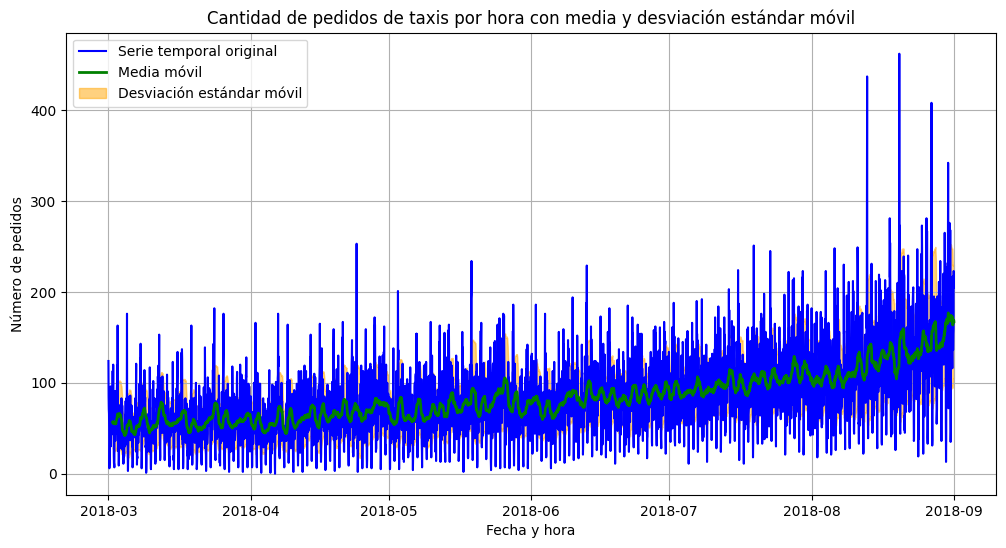

In [3]:
#5. Análisis de los datos
print("\nEstadísticas descriptivas del conjunto de datos remuestreado:")
print(data_hourly.describe())

# Calculo de la media móvil y desviación estándar móvil
window_size = 24  # Ventana de 24 horas (1 día)
data_hourly['mean'] = data_hourly['num_orders'].rolling(window=window_size).mean()
data_hourly['std'] = data_hourly['num_orders'].rolling(window=window_size).std()

# Gráfico de la serie temporal con media y desviación estándar móvil
plt.figure(figsize=(12, 6))
plt.plot(data_hourly.index, data_hourly['num_orders'], label='Serie temporal original', color='blue')
plt.plot(data_hourly.index, data_hourly['mean'], label='Media móvil', color='green', linewidth=2)
plt.fill_between(data_hourly.index, 
                 data_hourly['mean'] - data_hourly['std'], 
                 data_hourly['mean'] + data_hourly['std'], 
                 color='orange', alpha=0.5, label='Desviación estándar móvil')

plt.title('Cantidad de pedidos de taxis por hora con media y desviación estándar móvil')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de pedidos')
plt.legend()
plt.grid()
plt.show()


Descomposición de la serie temporal en tendencia, estacionalidad y residuos:


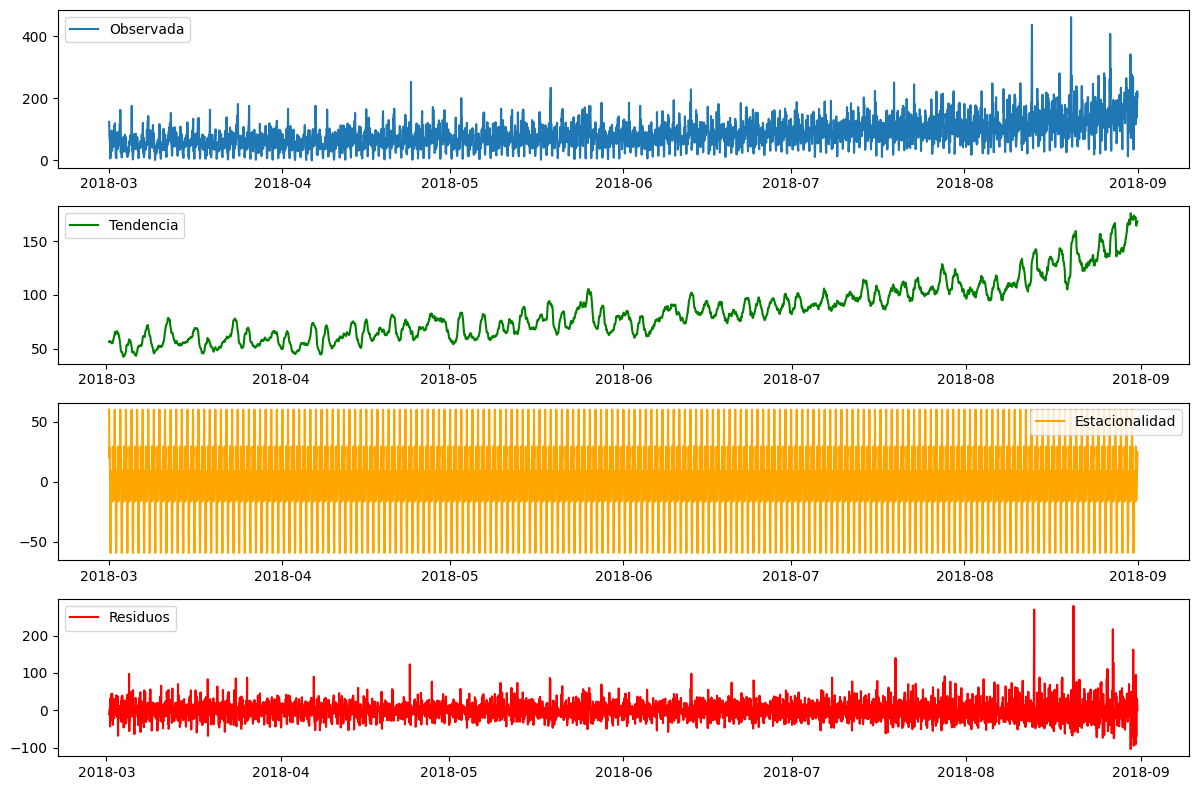

In [4]:
# 5.1 Descomposición de la serie temporal
print("\nDescomposición de la serie temporal en tendencia, estacionalidad y residuos:")
decomposition = seasonal_decompose(data_hourly['num_orders'], model='additive', period=24)

# Graficar la descomposición
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observada')
plt.legend()
plt.subplot(412)
plt.plot(decomposition.trend, label='Tendencia', color='green')
plt.legend()
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Estacionalidad', color='orange')
plt.legend()
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuos', color='red')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Crear nuevas características
print("\nCreando nuevas características basadas en fecha y tiempo:")
data_hourly['hour'] = data_hourly.index.hour
data_hourly['dayofweek'] = data_hourly.index.dayofweek
data_hourly['month'] = data_hourly.index.month
data_hourly['weekend'] = data_hourly['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

print(data_hourly.head())


Creando nuevas características basadas en fecha y tiempo:
                     num_orders  mean  std  hour  dayofweek  month  weekend
datetime                                                                   
2018-03-01 00:00:00         124   NaN  NaN     0          3      3        0
2018-03-01 01:00:00          85   NaN  NaN     1          3      3        0
2018-03-01 02:00:00          71   NaN  NaN     2          3      3        0
2018-03-01 03:00:00          66   NaN  NaN     3          3      3        0
2018-03-01 04:00:00          43   NaN  NaN     4          3      3        0


## Formación

In [7]:
# 6. Dividir los datos en conjuntos de entrenamiento y prueba
X = data_hourly[['hour', 'dayofweek', 'month', 'weekend']]
y = data_hourly['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

### Regresion Lineal

In [11]:
# 7. Modelo 1: Regresión Lineal
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"\nRECM en el conjunto de prueba (Regresión Lineal): {rmse_lr:.2f}")

# 8. Modelo 2: Random Forest (por defecto)
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"RECM en el conjunto de prueba (Random Forest): {rmse_rf:.2f}")

# 9. Modelo 3: Random Forest Optimizado
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

best_model_rf = grid_search.best_estimator_
y_pred_rf_opt = best_model_rf.predict(X_test)
rmse_rf_opt = np.sqrt(mean_squared_error(y_test, y_pred_rf_opt))
print(f"RECM en el conjunto de prueba (Random Forest Optimizado): {rmse_rf_opt:.2f}")


RECM en el conjunto de prueba (Regresión Lineal): 66.41
RECM en el conjunto de prueba (Random Forest): 46.96
Fitting 3 folds for each of 24 candidates, totalling 72 fits
RECM en el conjunto de prueba (Random Forest Optimizado): 48.57


## Prueba


Comparación de Resultados:
Regresión Lineal RECM: 66.41
Random Forest RECM: 46.96
Random Forest Optimizado RECM: 48.57


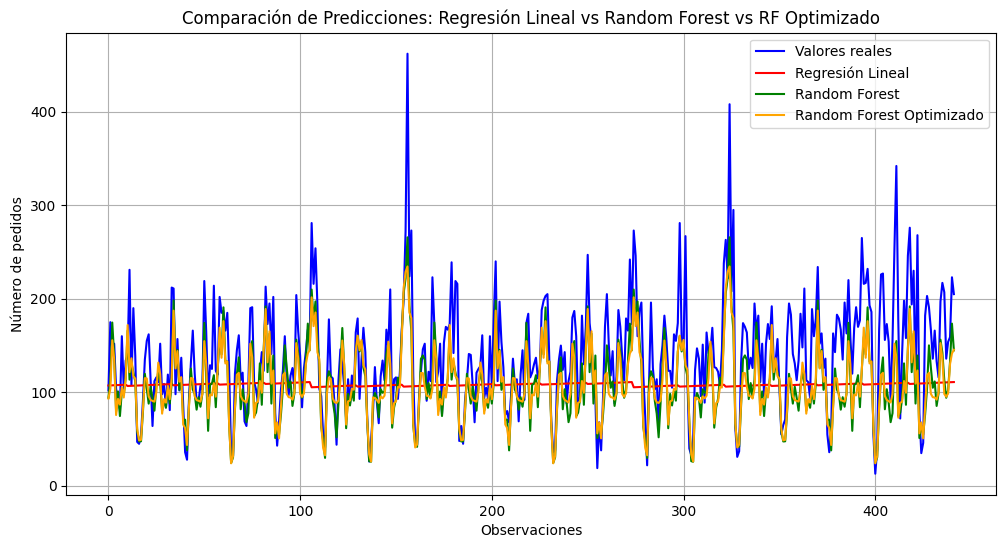

In [12]:
# 10. Comparación de Resultados
print("\nComparación de Resultados:")
print(f"Regresión Lineal RECM: {rmse_lr:.2f}")
print(f"Random Forest RECM: {rmse_rf:.2f}")
print(f"Random Forest Optimizado RECM: {rmse_rf_opt:.2f}")

# Gráfico de comparación de predicciones
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Valores reales', color='blue')
plt.plot(y_pred_lr, label='Regresión Lineal', color='red')
plt.plot(y_pred_rf, label='Random Forest', color='green')
plt.plot(y_pred_rf_opt, label='Random Forest Optimizado', color='orange')
plt.title('Comparación de Predicciones: Regresión Lineal vs Random Forest vs RF Optimizado')
plt.xlabel('Observaciones')
plt.ylabel('Número de pedidos')
plt.legend()
plt.grid()
plt.show()

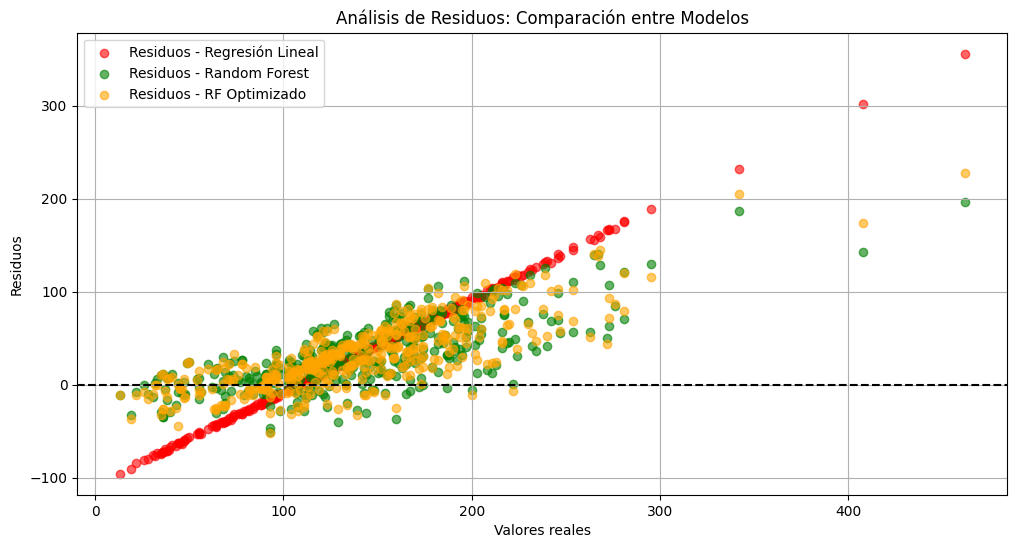


Validación cruzada (5 folds) para Random Forest Optimizado: RMSE promedio = 29.44, desviación estándar = 9.09


In [15]:
# 11. Análisis de errores: Gráfico de residuos
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test - y_pred_lr, label='Residuos - Regresión Lineal', color='red', alpha=0.6)
plt.scatter(y_test, y_test - y_pred_rf, label='Residuos - Random Forest', color='green', alpha=0.6)
plt.scatter(y_test, y_test - y_pred_rf_opt, label='Residuos - RF Optimizado', color='orange', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Análisis de Residuos: Comparación entre Modelos')
plt.xlabel('Valores reales')
plt.ylabel('Residuos')
plt.legend()
plt.grid()
plt.show()

# 12. Validación cruzada para Random Forest Optimizado
cv_scores = cross_val_score(best_model_rf, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"\nValidación cruzada (5 folds) para Random Forest Optimizado: RMSE promedio = {cv_rmse.mean():.2f}, desviación estándar = {cv_rmse.std():.2f}")

# Conclusión:

El modelo Random Forest sin optimización cumple con los requisitos del proyecto, alcanzando el mejor desempeño en términos de RECM. La optimización adicional mostró resultados estables y consistentes, validando la robustez del modelo. La comparación entre los modelos sugiere que Random Forest es una herramienta adecuada para este tipo de predicción debido a su capacidad de manejar datos complejos y capturar patrones no lineales.

Este modelo puede ser implementado para predecir los pedidos de taxis durante las horas pico, contribuyendo a una mejor planificación y atracción de conductores. 